# DS 6. 회귀분석문제 풀이, GradientTape를 이용한 풀이, GradientTape + opt.apply_gradients를 이용한 풀이, opt.minimize를 이용한 풀이, tf.keras.Sequential

> "작성완료"

- toc: true
- branch: master
- badges: true
- comments: true
- [python, Data Science]

---
# Data Science
- lenture: Data Science_5-2nd week of lectures.
- lenture date: 2022-04-04
- lecturer: Guebin choi
- study date: 2022-04-06
- author: Kione kim
---

In [1]:
# !conda install -c conda-forge python-graphviz -y

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow.experimental.numpy as tnp

In [4]:
tnp.experimental_enable_numpy_behavior()

## 회귀분석 문제

`-` ${\bf y} \approx 4 + 2.5 {\bf x}$

In [25]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

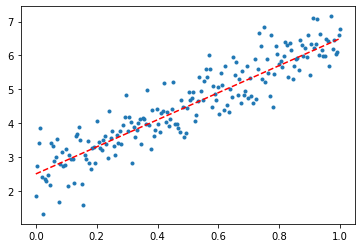

In [26]:
plt.plot(x,y,'.')
plt.plot(x,y_true,'r--')

---
### 이론적 풀이
`-` 지난 시간: 풀이1 ~ 풀이3

#### 풀이1: 스칼라버전

`-` 포인트 
- $S_{xx}=$, $S_{xy}=$
- $\hat{\beta}_0=$, $\hat{\beta}_1=$

In [10]:
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [11]:
Sxx=sum((x-x.mean())**2)
Sxy=sum((x-x.mean())*(y-y.mean()))

In [12]:
beta1_hat = Sxy/Sxx
beta0_hat = y.mean() - beta1_hat *x.mean()

In [13]:
beta0_hat, beta1_hat

(<tf.Tensor: shape=(), dtype=float64, numpy=2.4904666055923816>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4.100304074383147>)

#### 풀이2: 벡터버전

`-` 포인트
- $\hat{\beta}=(X'X)^{-1}X'y$

In [14]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 

In [15]:
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [16]:
tf.linalg.inv(X.T @ X) @ X.T @ y

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.49046661],
       [4.10030407]])>

#### 풀이3: 벡터버전, 손실함수의 도함수이용 

`-` 포인트
- $loss'(\beta)=-2X'y +2X'X\beta$
- $\beta_{new} = \beta_{old} - \alpha \times loss'(\beta_{old})$

In [17]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [18]:
beta_hat = tnp.array([-5,10]).reshape(2,1)
beta_hat

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[-5],
       [10]])>

In [19]:
alpha=0.1

$loss'(\beta) = -2X'y+2X'X\beta$

In [20]:
slope = -2*X.T @ y + 2*X.T@ X @ beta_hat 
slope

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-1816.24745711],
       [ -709.49075016]])>

In [21]:
step = - alpha*slope
step 

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[181.62474571],
       [ 70.94907502]])>

In [22]:
for epoc in range(1000):
    slope = (-2*X.T @ y + 2*X.T@ X @ beta_hat)/N
    step = - alpha * slope
    beta_hat = beta_hat + step 

In [23]:
beta_hat

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.49046015],
       [4.10031613]])>

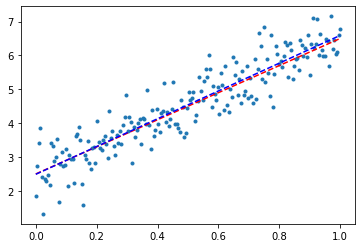

In [24]:
plt.plot(x,y,'.') 
plt.plot(x,y_true,'r--')
plt.plot(x,X@beta_hat,'b--')

---
### GradientTape를 이용한 풀이

`-` 포인트
```python
# 포인트 1: 그레디언트 테입  
with tf.GradientTape() as tape: 
    loss = (y-yhat).T @ (y-yhat) 
# 포인트 2: 미분 
slope = tape.gradient(loss,beta_hat) 
# 포인트 3: update 
beta_hat.assign_sub(slope*alph) 
```

#### 풀이1: 벡터버전

`-` 선언

In [77]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [78]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 

In [79]:
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [80]:
tnp.array([-5.0,-10.0]).reshape(2,1)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

`-` 임의의 beta_hat 선언

In [81]:
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [82]:
alpha=0.1

In [83]:
with tf.GradientTape(persistent=True) as tape:
    # tape.watch(beta_hat)
    yhat= X @ beta_hat
    loss= (y- yhat).T @ (y - yhat) /N

- loss를 SSE를 N으로 나눈 MSE를 사용함!
- SSE를 최소화하는 $beta$값이나 SSE를 N으로 나눈 MSE를 최소화 하는 $beta$값이랑 같기 때문에 MSE를 사용!
- 보통 SSE를 사용하긴 하지만, 머신러닝 & 딮러닝에선 MSE를 많이 사용함!
- MSE를 사용함으로써 loss값이 N으로 나눈 만큼 작아지기 때문에 alpha값을 지난 시간보다 키웠음 !

In [84]:
tape.gradient(loss,beta_hat) # loss를 beta_hat으로 미분

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-29.08123729],
       [-16.91428792]])>

- 미분 값 -> slope

`-` 반복

In [85]:
alpha=0.1

In [86]:
for epoc in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        yhat=X@beta_hat
        loss=(y-yhat).T @ (y-yhat) / N
    slope= tape.gradient(loss,beta_hat)
    beta_hat.assign_sub(slope*alpha)

In [87]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047318],
       [4.1002918 ]])>

- 풀이1~3에서 구한 $\beta$ 값과 같음

#### 풀이2: 스칼라버전

`-` 포인트
```python
# 포인트 : 미분
slope0, slope1 = tape.gradient(loss,[beta0_hat,beta1_hat])
```

In [106]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [107]:
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [108]:
beta0_hat= tf.Variable(-5.0)
beta1_hat= tf.Variable(-10.0)

In [109]:
alpha=0.1

In [112]:
for epoc in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        yhat= beta0_hat + beta1_hat*x
        loss= sum((y-yhat)**2) / N
    slope0, slope1= tape.gradient(loss,[beta0_hat,beta1_hat])
    beta0_hat.assign_sub(slope0*alpha)
    beta1_hat.assign_sub(slope1*alpha)

In [115]:
(beta0_hat,beta1_hat)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.4904754>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.1002874>)

``` python
for epoc in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        yhat= ,,,
        loss= ,,,
    slope0, slope1= tape.gradient(loss,[beta0_hat,beta1_hat])
    beta0_hat.assign_sub(slope0*alpha)
    beta1_hat.assign_sub(slope1*alpha)

: 1. loss를 beta0, beta1으로 각각 미분 -> 미분 값 2개 나오는데, beta0로 미분해준 값을 slope0로, beta1로 미분해준 값을 slope1로 받아줌!! 
  2. beta0_hat, beta1_hat값을 각각 변경!
```

- 코드에는 문제없지만, 시간이 매우 오래걸림..! 
- 다음과 같이 코딩하는 것이 훨씬 빠름!

`-` `sum()` 대신 `tf.reduce_sum` 사용!

In [114]:
for epoc in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        yhat= beta0_hat + beta1_hat*x
        loss= tf.reduce_sum((y-yhat)**2) / N
    slope0, slope1= tape.gradient(loss,[beta0_hat,beta1_hat])
    beta0_hat.assign_sub(slope0*alpha)
    beta1_hat.assign_sub(slope1*alpha)

In [116]:
(beta0_hat,beta1_hat)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.4904754>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.1002874>)

### GradientTape + opt.apply_gradients를 이용한 풀이

#### 풀이1: 벡터버전

`-` 포인트 
```python
# 포인트: 업데이트 방식
opt.apply_gradients([(slope,beta_hat)])  # pair의 list가 입력되어야 함!! 
```

In [144]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [145]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 

In [146]:
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [147]:
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [148]:
alpha=0.1

`-` `optimizer` 선언

In [149]:
opt= tf.optimizers.SGD(alpha)

**iter1**

In [150]:
with tf.GradientTape() as tape:
    yhat= X @ beta_hat
    loss= (y-yhat).T @ (y-yhat)/N
slope=tape.gradient(loss,beta_hat)
opt.apply_gradients([(slope,beta_hat)])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [151]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-2.09187623],
       [-8.30857118]])>

- 한 번 미분한 값!

**iter 반복**

In [152]:
for epoc in range(1000):
    with tf.GradientTape() as tape:
        yhat= X @ beta_hat
        loss= (y-yhat).T @ (y-yhat) / N
    slope= tape.gradient(loss,beta_hat)
    opt.apply_gradients([(slope,beta_hat)])

In [153]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047309],
       [4.10029197]])>

- `opt.apply_gradients([(slope,beta_hat)])`는 `beta_hat.assign_sub(slope*alpha)`와 같은 기능(업데이트)을 하는 코드

#### 풀이2: 스칼라버전

`-` 포인트
```python
# 포인트코드: loss beta0_hat, beta1_hat으로 각각 미분 -> 각각의 slope 값
slope0, slope1= tape.gradient(loss,[beta0_hat, beta1_hat])
# 포인트코드: 업데이트 
opt.apply_gradients([(slope0,beta0_hat),(slope1,beta1_hat)]) # pair의 list가 입력 
```

In [155]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [156]:
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [157]:
beta0_hat= tf.Variable(-5.0)
beta1_hat= tf.Variable(-10.0)

In [158]:
alpha=0.1

In [159]:
opt=tf.optimizers.SGD(alpha)

In [165]:
for epoc in range(1000):
    with tf.GradientTape() as tape:
        yhat= beta0_hat + beta1_hat*x
        loss= tf.reduce_sum((y-yhat)**2) / N
    slope0, slope1= tape.gradient(loss,[beta0_hat, beta1_hat])
    opt.apply_gradients([(slope0,beta0_hat), (slope1,beta1_hat)])

In [167]:
beta0_hat,beta1_hat

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.4904754>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.1002874>)

### opt.minimize를 이용한 풀이
: tf.GradientTape를 사용하지 않아도 됨. 어떤 계산식에 의해 미분값이 계산되는지 몰라도 쓸 수 있는 코드

#### 풀이1: 벡터버전, 사용자정의 손실함수(lambda)

`-` 포인트
```python
# 포인트1: 손실함수 정의 
loss_fn = lambda: ,,,

# 포인트2: 옵티마이저
opt = tf.optimizers.SGD(alpha)

# 포인트3: 미분 & 업데이트 = minimize 
opt.minimize(loss_fn,beta_hat)
```

In [209]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [210]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [211]:
alpha=0.1
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [212]:
opt=tf.optimizers.SGD(alpha)

``` python
opt.minimize(미분할 식, 미분하고자 하는 값)는 미분 + update를 동시에 수행

1. loss와 beta_hat값만 전달해주면 됨!!
2. loss는 사용자정의 함수로 전달
```

In [213]:
loss_fn = lambda:(y-X @ beta_hat).T @ (y-X @ beta_hat)/ N

**iter1**

In [214]:
opt.minimize(loss_fn,beta_hat)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [215]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-2.09187623],
       [-8.30857118]])>

**iter반복**

In [216]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat)

In [217]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047309],
       [4.10029197]])>

#### 풀이2:스칼라 버전, 사용자정의 손실함수(lambda)

`-` 포인트
```python
# 포인트: 미분 & 업데이트 = minimize 
opt.minimize(loss_fn,[beta0_hat,beta1_hat])
```

In [219]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [220]:
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [222]:
beta0_hat= tf.Variable(-5.0)
beta1_hat= tf.Variable(-10.0)

In [223]:
alpha=0.1

In [224]:
opt=tf.optimizers.SGD(alpha)

In [225]:
loss_fn= lambda: tf.reduce_sum((y-(beta0_hat+beta1_hat*x))**2) / N

**iter1**

In [226]:
opt.minimize(loss_fn,[beta0_hat,beta1_hat])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [227]:
beta0_hat,beta1_hat

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-2.0918763>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-8.308571>)

**iter반복**

In [229]:
for epoc in range(1000):
    opt.minimize(loss_fn,[beta0_hat,beta1_hat])

In [230]:
beta0_hat,beta1_hat

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.4904754>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.1002874>)

#### lambda 함수

`-` 입력이 있는 형태
- `lambda x: x**2` => `lambda(x) = x^2`
- `lambda x,y: x+y` => `lambda(x,y) = x+y`

`-` 입력이 없는 형태
- `lambda: y` => `lamnda() = y`

: 입력이 무엇이든 `y`를 출력하는 함수!

-> `lambda: tf.reduce_sum((y-(beta0_hat+beta1_hat*x))**2)` => `lambda() = tf.reduce_sum(y-(beta0_hat+beta1_hat*x))`

: 입력이 무엇이든 `tf.reduce_sum(y-(beta0_hat+beta1_hat*x))`를 출력하는 함수

#### 풀이3: 벡터버전, 사용자정의 손실함수(def)

`-` 포인트
```python
# 포인트: 손실함수정의 
def loss_fn():
    return ,,,
```

In [245]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [246]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [247]:
alpha=0.1
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [248]:
opt=tf.optimizers.SGD(alpha)

In [249]:
def loss_fn():
    return tf.reduce_sum((y-X@beta_hat).T @ (y-X@beta_hat)) / N

**iter1**

In [250]:
opt.minimize(loss_fn,beta_hat)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [251]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-2.09187623],
       [-8.30857118]])>

**iter반복**

In [252]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat)

In [253]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047309],
       [4.10029197]])>

- 이 코드가 좋은 이유: 사용자 정의 함수를 내가 원하는 형태로 정의하여 사용할 수 있음!

#### 풀이4: 벡터버전, 사용자정의 손실함수(def)

`-` 포인트
```python
# 포인트: 손실함수정의 
def loss_fn():
    yhat=
    loss=
    ,,,
    return loss
```

`-` 예시

In [258]:
def loss_fn():
    yhat= X@beta_hat
    loss= (y-yhat).T @ (y-yhat) / N
    return loss # loss가 출력

- 입력값이 무엇이든 loss가 출력됨. loss는 우리가 미분하고자 하는 식

In [256]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat)

In [257]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49046661],
       [4.10030407]])>

- 내가 원하는 형태의 코딩이 가능

#### 풀이5: 벡터버전, 사용자정의 손실함수(tf.losses.MSE)

`-` 포인트
```python
# 포인트: 이미 구현되어 있는 손실함수 이용 
tf.losses.MSE(y,yhat)
```

In [260]:
tf.losses.MSE(tnp.array([1.0,2.0,3.0]), tnp.array([0.0,0.0,0.0]))

<tf.Tensor: shape=(), dtype=float64, numpy=4.666666666666667>

In [262]:
(1+4+9)/3

4.666666666666667

In [263]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [264]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [265]:
alpha=0.1
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [266]:
opt=tf.optimizers.SGD(alpha)

In [268]:
yhat= X @ beta_hat

In [269]:
tf.losses.MSE(y,yhat)

<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([ 46.96022558,  60.70686684,  72.30282228,  81.2802598 ,
        57.80729918,  43.17952069,  58.53054446,  58.31180694,
        61.85092764,  58.31730177,  79.71547263,  78.60501259,
        71.99894261,  75.00602384,  85.12349938,  55.10406785,
        73.69786462,  80.95467083,  74.6669447 ,  75.82773797,
        85.53770852,  67.22515134,  83.92316782,  82.73476828,
        83.61351332,  71.88184929,  98.56777325, 100.69671217,
       106.00993654,  99.11303261,  75.80120511,  66.43965872,
        93.29103212,  92.02161062, 103.43848691,  91.95513609,
        89.55063202, 102.5791008 , 104.04281702,  95.9503876 ,
       122.33084547, 110.14601438, 107.8128172 , 107.24683005,
       114.95773419, 118.679864  , 114.32865366, 106.48965615,
       138.72702545, 121.53161946, 127.26461033, 118.57340053,
       113.79996022, 127.69733957, 123.58570914, 132.75464371,
       125.47854101, 139.15373989, 146.19252441, 163.53659744,
       

- 매트릭스 형태로 되어 있어 벡터 형태로 변환해서 입력해야 함

In [275]:
tf.losses.MSE(y.reshape(-1), yhat.reshape(-1))

<tf.Tensor: shape=(), dtype=float64, numpy=228.42737562724935>

`-` 손실함수 정의

In [276]:
def loss_fn():
    yhat= X @ beta_hat
    loss= tf.losses.MSE(y.reshape(-1), yhat.reshape(-1))
    return loss

In [277]:
for epoc in range(1000):
    opt.minimize(loss_fn, beta_hat)

In [278]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047318],
       [4.1002918 ]])>

- 단점: 차원을 조절해주어야 함. 스칼라 값이 나오도록,,

#### 풀이6: 벡터버전, 사용자정의 손실함수(tf.losses.MeanSquaredError)

`-` 포인트
```python
# 포인트: 클래스로부터 손실함수 오브젝트 생성 (함수를 찍어내는 클래스) 
mse_fn = tf.losses.MeanSquaredError()
mse_fn(y,yhat)
```

In [317]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [318]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [319]:
alpha=0.1
beta_hat = tf.Variable(tnp.array([-5.0,-10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[ -5.],
       [-10.]])>

In [320]:
opt=tf.optimizers.SGD(alpha)

In [312]:
mseloss_fn = tf.losses.MeanSquaredError()

In [284]:
mseloss_fn(y.reshape(-1),yhat.reshape(-1))

<tf.Tensor: shape=(), dtype=float64, numpy=228.4273681640625>

- 이것도 스칼라 값이 나오도록 차원을 조절해주어야 함!

`-` 손실함수 정의

In [285]:
def loss_fn():
    yhat= X @ beta_hat
    loss= mseloss_fn(y.reshape(-1),yhat.reshape(-1))
    return loss

In [287]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat)

In [288]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.49047309],
       [4.10029197]])>

`-` 오류

In [325]:
def loss_fn():
    yhat= X @ beta_hat
    loss=  tf.losses.MeanSquaredError((y.reshape(-1),yhat.reshape(-1)))
    return loss

In [326]:
for epoc in range(1000):
    opt.minimize(loss_fn,beta_hat)

ValueError: Invalid Reduction Key: (<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([1.85275314, 2.74120989, 3.40260411, 3.86480278, 2.40210613,
       1.31985631, 2.34901823, 2.284458  , 2.46252602, 2.18431527,
       3.42583962, 3.31318298, 2.88220399, 3.00733549, 3.52272213,
       1.66944258, 2.78072594, 3.14321   , 2.73648107, 2.75313851,
       3.2436347 , 2.14381816, 3.05543125, 2.94008656, 2.93801235,
       2.22203501, 3.62159774, 3.67799122, 3.88907751, 3.49826642,
       2.19885106, 1.59326367, 3.05068809, 2.93449805, 3.46192861,
       2.8305301 , 2.65407435, 3.26883764, 3.29059035, 2.83562788,
       4.0502773 , 3.43474563, 3.27274234, 3.19520052, 3.51077918,
       3.63272229, 3.3809    , 2.9575735 , 4.36618343, 3.56182648,
       3.76859893, 3.32632733, 3.05464109, 3.63700817, 3.40334311,
       3.75810104, 3.3876501 , 3.93202274, 4.1764372 , 4.82331873,
       3.77892584, 4.19113873, 4.02716554, 2.8140508 , 3.89742531,
       3.60297001, 3.78792647, 4.0092427 , 4.12447136, 3.36998897,
       4.16143963, 4.11805975, 3.96581155, 4.97139214, 3.94345412,
       3.24070572, 4.39414946, 3.61984367, 3.7961167 , 4.43103737,
       3.98777658, 3.74862454, 4.31428866, 4.36668221, 5.19459834,
       4.02190318, 4.33428583, 3.90140176, 4.13467048, 4.40997807,
       5.20239075, 3.97708338, 3.98520656, 3.85117406, 3.74914404,
       4.67870071, 4.46237022, 3.5934099 , 3.72163712, 4.45973941,
       4.90984728, 4.68912881, 4.73814294, 4.90688137, 4.0750479 ,
       4.23430813, 4.66331426, 5.35246718, 4.94899606, 4.66880361,
       5.24563146, 5.59203164, 5.34975923, 6.01682146, 5.5964797 ,
       4.47640444, 5.09951338, 4.86402962, 4.69337013, 5.07779304,
       4.2768764 , 5.47826588, 5.11181129, 4.39901233, 5.7005923 ,
       4.52352963, 4.33796533, 5.02068374, 4.77431511, 5.96587303,
       5.42926138, 5.81810993, 4.82592311, 5.30058169, 4.59379835,
       5.54801606, 4.82574257, 4.95804583, 5.68060751, 4.74627408,
       5.34710083, 4.81312113, 4.59568804, 5.90109513, 4.72232315,
       5.59658612, 6.65415208, 6.28138025, 5.30809268, 6.83666644,
       5.21272686, 5.90825308, 5.4791133 , 4.8048449 , 6.59485311,
       4.48556154, 5.45602146, 6.28308931, 6.02768964, 5.73520098,
       5.83256331, 5.65601759, 5.96936635, 6.39725355, 6.31677447,
       5.35624566, 6.36368854, 6.16924599, 5.2890948 , 5.69414292,
       5.88715305, 5.90918155, 5.57644188, 6.44633357, 6.30203093,
       5.99376212, 6.23239137, 5.94669229, 6.61552144, 5.4339177 ,
       6.32816074, 7.09476023, 6.21127041, 6.35112611, 7.07523998,
       6.01315549, 6.62756748, 6.15184238, 5.9967824 , 5.99419475,
       6.47049184, 6.42301354, 5.69924333, 7.15647568, 6.18485576,
       6.44671813, 6.05208212, 6.0912541 , 6.61551979, 6.77698431])>, <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([2.49047318, 2.51107766, 2.53168214, 2.55228662, 2.5728911 ,
       2.59349559, 2.61410007, 2.63470455, 2.65530903, 2.67591351,
       2.69651799, 2.71712247, 2.73772696, 2.75833144, 2.77893592,
       2.7995404 , 2.82014488, 2.84074936, 2.86135384, 2.88195832,
       2.90256281, 2.92316729, 2.94377177, 2.96437625, 2.98498073,
       3.00558521, 3.02618969, 3.04679418, 3.06739866, 3.08800314,
       3.10860762, 3.1292121 , 3.14981658, 3.17042106, 3.19102555,
       3.21163003, 3.23223451, 3.25283899, 3.27344347, 3.29404795,
       3.31465243, 3.33525692, 3.3558614 , 3.37646588, 3.39707036,
       3.41767484, 3.43827932, 3.4588838 , 3.47948829, 3.50009277,
       3.52069725, 3.54130173, 3.56190621, 3.58251069, 3.60311517,
       3.62371966, 3.64432414, 3.66492862, 3.6855331 , 3.70613758,
       3.72674206, 3.74734654, 3.76795103, 3.78855551, 3.80915999,
       3.82976447, 3.85036895, 3.87097343, 3.89157791, 3.9121824 ,
       3.93278688, 3.95339136, 3.97399584, 3.99460032, 4.0152048 ,
       4.03580928, 4.05641377, 4.07701825, 4.09762273, 4.11822721,
       4.13883169, 4.15943617, 4.18004065, 4.20064514, 4.22124962,
       4.2418541 , 4.26245858, 4.28306306, 4.30366754, 4.32427202,
       4.34487651, 4.36548099, 4.38608547, 4.40668995, 4.42729443,
       4.44789891, 4.46850339, 4.48910788, 4.50971236, 4.53031684,
       4.55092132, 4.5715258 , 4.59213028, 4.61273476, 4.63333925,
       4.65394373, 4.67454821, 4.69515269, 4.71575717, 4.73636165,
       4.75696613, 4.77757062, 4.7981751 , 4.81877958, 4.83938406,
       4.85998854, 4.88059302, 4.9011975 , 4.92180199, 4.94240647,
       4.96301095, 4.98361543, 5.00421991, 5.02482439, 5.04542887,
       5.06603336, 5.08663784, 5.10724232, 5.1278468 , 5.14845128,
       5.16905576, 5.18966024, 5.21026473, 5.23086921, 5.25147369,
       5.27207817, 5.29268265, 5.31328713, 5.33389161, 5.3544961 ,
       5.37510058, 5.39570506, 5.41630954, 5.43691402, 5.4575185 ,
       5.47812298, 5.49872747, 5.51933195, 5.53993643, 5.56054091,
       5.58114539, 5.60174987, 5.62235435, 5.64295884, 5.66356332,
       5.6841678 , 5.70477228, 5.72537676, 5.74598124, 5.76658572,
       5.7871902 , 5.80779469, 5.82839917, 5.84900365, 5.86960813,
       5.89021261, 5.91081709, 5.93142157, 5.95202606, 5.97263054,
       5.99323502, 6.0138395 , 6.03444398, 6.05504846, 6.07565294,
       6.09625743, 6.11686191, 6.13746639, 6.15807087, 6.17867535,
       6.19927983, 6.21988431, 6.2404888 , 6.26109328, 6.28169776,
       6.30230224, 6.32290672, 6.3435112 , 6.36411568, 6.38472017,
       6.40532465, 6.42592913, 6.44653361, 6.46713809, 6.48774257,
       6.50834705, 6.52895154, 6.54955602, 6.5701605 , 6.59076498])>). Expected keys are "('auto', 'none', 'sum', 'sum_over_batch_size')"

- 이는 오류

### tf.keras.Sequential

`-` $\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$ 의 서로다른 표현 

In [5]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

`-` 방식1: 스칼라버전, `bias=False`

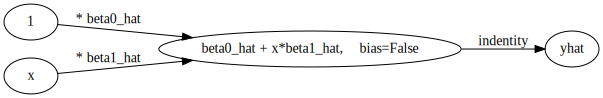

In [6]:
gv(''' 
    "1" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta0_hat"]
    "x" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta1_hat"]
    "beta0_hat + x*beta1_hat,    bias=False" -> "yhat"[label="indentity"]
    ''')

`-` 방식2: 스칼라버전, `bias=True`

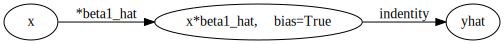

In [7]:
gv('''
"x" -> "x*beta1_hat,    bias=True"[label="*beta1_hat"] ;
"x*beta1_hat,    bias=True" -> "yhat"[label="indentity"] ''')


`-` 방식3: 벡터버전, `bias=False`

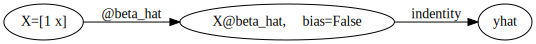

In [8]:
gv('''
"X=[1 x]" -> "X@beta_hat,    bias=False"[label="@beta_hat"] ;
"X@beta_hat,    bias=False" -> "yhat"[label="indentity"] ''')


#### 풀이1: 벡터버전, 사용자정의 손실함수 

`-` 포인트
```python
# 포인트1: 네트워크 생성 
net = tf.keras.Sequential()

# 포인트2: 네트워크의 아키텍처 설계 
net.add(tf.keras.layers.Dense(1,input_shape=(2,),use_bias=False)) 

# 포인트3: 네트워크 컴파일 = 아키텍처 + 손실함수 + 옵티마이저
net.compile(opt,loss=loss_fn2)

# 포인트4: 미분 & update 
net.fit(X,y,epochs=1000,verbose=0,batch_size=N) 
```

In [12]:
tnp.random.seed(50000)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

In [13]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

`-` 네트워크 생성

In [14]:
net = tf.keras.Sequential() 

In [16]:
net.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

- 현재 아무것도 없음
- 다음과 같이 layer를 만들어야 함

`-` 네트워크의 아키텍처 설계

In [39]:
net.add(tf.keras.layers.Dense(units=1,input_shape=(2,),use_bias=False)) # 뼈대, 아키텍처 설계 = yhat을 만들 계획

In [40]:
net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 dense_2 (Dense)             (None, 1)                 1         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


- 무엇인가 나왔음!
- layer가 추가된 것임

- `units=1:` 출력의 차원
- `input_shape:` x의 dimension
- `use_bias:` bias 사용여부

`-` 네트워크 컴파일(아키텍처, 손실함수, 옵티마이저)

In [41]:
def loss_fn2(y,yhat): # 손실함수 정의, 입력값이 항상 y, yhat이 와야함
    return (y-yhat).T @ (y-yhat) / N

In [42]:
alpha=0.1

In [45]:
opt=tf.optimizers.SGD(alpha) # 옵티마이저 선택

In [48]:
net.compile(opt,loss=loss_fn2) # 컴파일 = 아키텍처 + 손실함수 + 옵티마이저

- 네트워크의 형태(아키텍처), 손실함수, 손실함수를 미분할 옵티마이저 전달

`-` 네트워크 적합: `for문-미분-업데이트`의 기능

In [36]:
net.fit(X,y,epochs=10,batch_size=N)

Epoch 1/10
1/1 [==============================] - 0s 332ms/step - loss: 0.2631
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2631
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.2631
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2631
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.2631
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2631
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.2631
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2631
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.2631
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.2631


- `verbose=0`사용 -> 적합되는 과정 생략

In [50]:
net.fit(X,y,epochs=10,verbose=0,batch_size=N) # 미분 & update의 반복, epochs= 반복 수, batch_size= 일단 N

- 이에 대해 적합된 결과는 `net.weights`를 통해 알 수 있음

In [38]:
net.weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[2.4904754],
        [4.1002874]], dtype=float32)>]

```python
정리:
1. net = tf.keras.Sequential()
2. net.add(tf.keras.layers.Dense(units=1,input_shape=(2,),use_bias=False))
3-1. def loss_fn2(y,yhat): # 입력값이 항상 y, yhat이 와야함
    return (y-yhat).T @ (y-yhat) / N
3-2. alpha=0.1
3-3. opt=tf.optimizers.SGD(alpha)
3-4. net.compile(opt,loss=loss_fn2)
4. net.fit(X,y,epochs=10,verbose=0,batch_size=N)
5. net.weights

1. 네트워크 생성
2. 하나의 layer(층) 추가(여러 layer도 추가 가능)
  아키텍처 설계: 입력을 가지고 출력을 어떠한 방식으로 만들 것인지 컴퓨터에게 전달해주는 것. 여기서, x를 가지고 yhat을 어떠한 방식으로 만들 것인지 컴퓨터에게 전달해주는 것.
3-1. 손실함수 정의
3-2. 옵티마이저 정의 위해 학습율 설정
3-3. 옵티마이저 오브젝트 생성
3-4. 옵티마이저 오브젝트, 손실함수를 네트워크에 알려줌
4. 미분 & 업데이트의 반복(for문)
5. 결과값 확인
```